<a href="https://colab.research.google.com/github/safin777/SmartFarming/blob/main/SmartFarming.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Download a file based on its file ID.
file_id = '1H7vkuA_leohKTlp2bIS61oL9XOGoAk_4'

# Download dataset
!gdown https://drive.google.com/uc?id={file_id}

# Unzip the downloaded file
!unzip -q tomato.zip

Downloading...
From: https://drive.google.com/uc?id=1H7vkuA_leohKTlp2bIS61oL9XOGoAk_4
To: /content/tomato.zip
192MB [00:00, 222MB/s]
replace tomato/cnn_train.py? [y]es, [n]o, [A]ll, [N]one, [r]ename: None


In [3]:
import numpy as np
import pickle
import cv2
import os
import matplotlib.pyplot as plt
from os import listdir
from sklearn.preprocessing import LabelBinarizer
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation, Flatten, Dropout, Dense
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.preprocessing import image
from keras.preprocessing.image import img_to_array
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split

Importing the libraries

# Load Dataset

Initializing a few parameters required for the image dataset preprocessing

In [5]:
# Dimension of resized image
DEFAULT_IMAGE_SIZE = tuple((256, 256))

# Number of images used to train the model
N_IMAGES = 100

# Path to the dataset folder
root_dir = './tomato'

train_dir = os.path.join(root_dir, 'train')
val_dir = os.path.join(root_dir, 'val')

We use the function convert_image_to_array to resize an image to the size DEFAULT_IMAGE_SIZE we defined above.

In [6]:
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None:
            image = cv2.resize(image, DEFAULT_IMAGE_SIZE)   
            return img_to_array(image)
        else:
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None


Here, we load the training data images by traversing through all the folders and converting all the images and labels into separate lists respectively.

NOTE: We use a small portion of the entire dataset due to the computing limitations. Tweak N_IMAGES to include entire dataset.

In [7]:
image_list, label_list =[], []

try: 
  print("[INFO] Loading image......")
  plant_disease_folder_list = listdir(train_dir)

  for plant_disease_folder in plant_disease_folder_list:
    print(f"[INFO] Processing {plant_disease_folder}......")
    plant_disease_image_list = listdir(f"{train_dir}/{plant_disease_folder}/")

    for image in plant_disease_image_list[:N_IMAGES]:
      image_directory = f"{train_dir}/{plant_disease_folder}/{image}"
      if image_directory.endswith(".jpg")==True or image_directory.endswith(".JPG")==True:
                image_list.append(convert_image_to_array(image_directory))
                label_list.append(plant_disease_folder)

    print("[INFO] Image loading completed")  
except Exception as e:
    print(f"Error : {e}")

# Transform the loaded training image data into numpy array
np_image_list = np.array(image_list, dtype=np.float16) / 225.0
print()

# Check the number of images loaded for training
image_len = len(image_list)
print(f"Total number of images: {image_len}")


[INFO] Loading image......
[INFO] Processing Tomato___Late_blight......
[INFO] Image loading completed
[INFO] Processing Tomato___Leaf_Mold......
[INFO] Image loading completed
[INFO] Processing Tomato___Tomato_mosaic_virus......
[INFO] Image loading completed
[INFO] Processing Tomato___Septoria_leaf_spot......
[INFO] Image loading completed
[INFO] Processing Tomato___Target_Spot......
[INFO] Image loading completed
[INFO] Processing Tomato___Spider_mites Two-spotted_spider_mite......
[INFO] Image loading completed
[INFO] Processing Tomato___healthy......
[INFO] Image loading completed
[INFO] Processing Tomato___Bacterial_spot......
[INFO] Image loading completed
[INFO] Processing Tomato___Early_blight......
[INFO] Image loading completed
[INFO] Processing Tomato___Tomato_Yellow_Leaf_Curl_Virus......
[INFO] Image loading completed

Total number of images: 1000


Examine the labels/classes in the training dataset.

In [9]:
label_binarizer = LabelBinarizer()
image_labels = label_binarizer.fit_transform(label_list)

pickle.dump(label_binarizer,open('plant_disease_label_transform.pkl', 'wb'))
n_classes = len(label_binarizer.classes_)

print("Total number of classes: ", n_classes)

Total number of classes:  10


#Augment and Split Dataset

Using ImageDataGenerator to augment data by performing various operations on the training images.

In [10]:
augment = ImageDataGenerator(rotation_range=25, width_shift_range=0.1,
                             height_shift_range=0.1, shear_range=0.2, 
                             zoom_range=0.2, horizontal_flip=True, 
                             fill_mode="nearest")

Splitting the data into training and test sets for validation purpose.

In [11]:
print("[INFO] Splitting data to train and test...")
x_train, x_test, y_train, y_test = train_test_split(np_image_list, image_labels, test_size=0.2, random_state = 42) 

[INFO] Splitting data to train and test...


# Build Model

Defining the hyperparameters of the plant disease classification model.

In [12]:
EPOCHS = 25
STEPS = 100
LR = 1e-3
BATCH_SIZE = 32
WIDTH = 256
HEIGHT = 256
DEPTH = 3

Creating a sequential model and adding Convolutional, Normalization, Pooling, Dropout and Activation layers at the appropriate positions.

In [14]:
model = Sequential()
inputShape = (HEIGHT, WIDTH, DEPTH)
chanDim = -1

if K.image_data_format() == "channels_first":
    inputShape = (DEPTH, HEIGHT, WIDTH)
    chanDim = 1

model.add(Conv2D(32, (3,3), padding="same",input_shape=inputShape))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3,3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(64, (3,3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(128, (3,3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(128, (3,3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(1024))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(n_classes))
model.add(Activation("softmax"))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 256, 256, 32)      896       
_________________________________________________________________
activation_7 (Activation)    (None, 256, 256, 32)      0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 256, 256, 32)      128       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 128, 128, 32)      0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 128, 128, 64)      18496     
_________________________________________________________________
activation_8 (Activation)    (None, 128, 128, 64)     

# Train Model


We initialize Adam optimizer with learning rate and decay parameters.

Also, we choose the type of loss and metrics for the model and compile it for training

In [15]:
# Initialize optimizer
opt = Adam(lr=LR, decay=LR / EPOCHS)

# Compile model
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

# Train model
print("[INFO] Training network...")
history = model.fit(augment.flow(x_train, y_train, batch_size=BATCH_SIZE),
                              validation_data=(x_test, y_test),
                              steps_per_epoch=len(x_train) // BATCH_SIZE,
                              epochs=EPOCHS, 
                              verbose=1)

[INFO] Training network...
Epoch 1/25
25/25 [==============================] - 314s 13s/step - loss: 0.3241 - accuracy: 0.3862 - val_loss: 2.3070 - val_accuracy: 0.0650
Epoch 2/25
25/25 [==============================] - 312s 12s/step - loss: 0.2093 - accuracy: 0.5587 - val_loss: 2.8680 - val_accuracy: 0.0650
Epoch 3/25
25/25 [==============================] - 314s 13s/step - loss: 0.1807 - accuracy: 0.6375 - val_loss: 2.8680 - val_accuracy: 0.0650
Epoch 4/25
25/25 [==============================] - 311s 12s/step - loss: 0.2128 - accuracy: 0.6125 - val_loss: 2.1187 - val_accuracy: 0.0650
Epoch 5/25
25/25 [==============================] - 312s 12s/step - loss: 0.1997 - accuracy: 0.6450 - val_loss: 2.0952 - val_accuracy: 0.0650
Epoch 6/25
25/25 [==============================] - 313s 13s/step - loss: 0.1739 - accuracy: 0.6750 - val_loss: 2.1492 - val_accuracy: 0.0650
Epoch 7/25
25/25 [==============================] - 312s 12s/step - loss: 0.1633 - accuracy: 0.6875 - val_loss: 1.4046 - 

#Evaluate Model


Comparing the accuracy and loss by plotting the graph for training and validation.

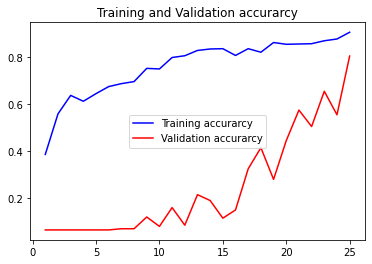

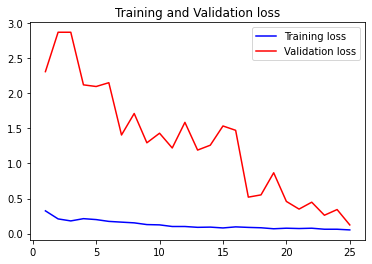

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

# Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()

# Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

Evaluating model accuracy by using the evaluate method

In [17]:
print("[INFO] Calculating model accuracy")
scores = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {scores[1]*100}")

[INFO] Calculating model accuracy
7/7 [==============================] - 14s 2s/step - loss: 0.1236 - accuracy: 0.8050
Test Accuracy: 80.50000071525574
